In [ ]:
!pip install opendatasets --quiet  # Se estiver em local que permita instalação via pip

import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models

In [ ]:
import opendatasets as od

# URL no UCI - Ajuste se necessário ao link direto do arquivo .zip
dataset_url = 'https://archive.ics.uci.edu/static/public/908/realwaste.zip'

od.download(dataset_url, data_dir='.')

688545792it [00:13, 52689688.79it/s]


In [ ]:
import os
import zipfile
import random
import shutil

# 1. Baixar (opcional, caso não tenha o ZIP localmente):
# Se você já tem o .zip local, pode pular esta etapa.
if not os.path.exists('realwaste.zip'):
    !wget -O realwaste.zip "https://archive.ics.uci.edu/ml/machine-learning-databases/00808/RealWaste.zip"

# 2. Descompactar o ZIP em uma pasta temporária
zip_ref = zipfile.ZipFile('realwaste.zip', 'r')
zip_ref.extractall('RealWaste_unzipped')
zip_ref.close()

# A pasta "RealWaste_unzipped" agora contém os arquivos extraídos.
# Precisamos verificar como o dataset está estruturado lá dentro.

# 3. Verificar se há subpastas ou se as imagens estão todas juntas.
SOURCE_DIR = '/content/RealWaste_unzipped/realwaste-main/RealWaste'
classes = ["Cardboard", "Food Organics", "Glass", "Metal", "Miscellaneous Trash", "Paper", "Plastic", "Textile Trash", "Vegetation"]

# Verificamos se as classes existem na pasta-fonte
for cls in classes:
    if not os.path.exists(os.path.join(SOURCE_DIR, cls)):
        raise RuntimeError(f"A subpasta '{cls}' não foi encontrada em {SOURCE_DIR}. Ajuste o script conforme a estrutura real do dataset.")

# 4. Criar as pastas de destino: RealWaste/train, RealWaste/val, RealWaste/test
base_dir = 'RealWaste'  # pasta final
os.makedirs(base_dir, exist_ok=True)

splits = ['train', 'val', 'test']
for sp in splits:
    split_path = os.path.join(base_dir, sp)
    os.makedirs(split_path, exist_ok=True)
    # criar subpastas de classes
    for cls in classes:
        class_path = os.path.join(split_path, cls)
        os.makedirs(class_path, exist_ok=True)

# 5. Definir a proporção de split (por exemplo, 60% - 20% - 20%)
train_ratio = 0.6
val_ratio   = 0.2
test_ratio  = 0.2

# 6. Para cada classe, listamos as imagens, embaralhamos e dividimos
for cls in classes:
    class_folder = os.path.join(SOURCE_DIR, cls)
    all_images = os.listdir(class_folder)

    # Filtrar apenas arquivos de imagem (jpg, png, etc.) se necessário
    all_images = [img for img in all_images if img.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))]

    # Embaralhar aleatoriamente
    random.shuffle(all_images)

    total_images = len(all_images)
    train_end = int(train_ratio * total_images)
    val_end   = int((train_ratio + val_ratio) * total_images)

    train_files = all_images[:train_end]
    val_files   = all_images[train_end:val_end]
    test_files  = all_images[val_end:]

    # Copiar arquivos para as pastas destino
    for f in train_files:
        src = os.path.join(class_folder, f)
        dst = os.path.join(base_dir, 'train', cls, f)
        shutil.copy2(src, dst)

    for f in val_files:
        src = os.path.join(class_folder, f)
        dst = os.path.join(base_dir, 'val', cls, f)
        shutil.copy2(src, dst)

    for f in test_files:
        src = os.path.join(class_folder, f)
        dst = os.path.join(base_dir, 'test', cls, f)
        shutil.copy2(src, dst)

print("Estrutura de pastas criada com sucesso em 'RealWaste/'.")
print("Estrutura final:")
print(f"  RealWaste/")
print(f"    ├─ train/")
for cls in classes:
    print(f"    │    └─ {cls}/  ...")
print(f"    ├─ val/")
for cls in classes:
    print(f"    │    └─ {cls}/  ...")
print(f"    └─ test/")
for cls in classes:
    print(f"         └─ {cls}/  ...")


Estrutura de pastas criada com sucesso em 'RealWaste/'.
Estrutura final:
  RealWaste/
    ├─ train/
    │    └─ Cardboard/  ...
    │    └─ Food Organics/  ...
    │    └─ Glass/  ...
    │    └─ Metal/  ...
    │    └─ Miscellaneous Trash/  ...
    │    └─ Paper/  ...
    │    └─ Plastic/  ...
    │    └─ Textile Trash/  ...
    │    └─ Vegetation/  ...
    ├─ val/
    │    └─ Cardboard/  ...
    │    └─ Food Organics/  ...
    │    └─ Glass/  ...
    │    └─ Metal/  ...
    │    └─ Miscellaneous Trash/  ...
    │    └─ Paper/  ...
    │    └─ Plastic/  ...
    │    └─ Textile Trash/  ...
    │    └─ Vegetation/  ...
    └─ test/
         └─ Cardboard/  ...
         └─ Food Organics/  ...
         └─ Glass/  ...
         └─ Metal/  ...
         └─ Miscellaneous Trash/  ...
         └─ Paper/  ...
         └─ Plastic/  ...
         └─ Textile Trash/  ...
         └─ Vegetation/  ...


In [ ]:
# Ajuste conforme a extração do RealWaste:
base_dir = 'RealWaste'  # pasta onde foram extraídos os dados

train_dir = os.path.join(base_dir, 'train')
val_dir   = os.path.join(base_dir, 'val')
test_dir  = os.path.join(base_dir, 'test')

# Parâmetros de pré-processamento:
IMG_HEIGHT, IMG_WIDTH = 224, 224   # Ajuste conforme necessidade
BATCH_SIZE = 32
EPOCHS = 10
NUM_CLASSES = 9  # glass, metal, paper, plastic


In [ ]:
# Data augmentation no conjunto de treino
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Apenas normalização (sem augmentation) em validação e teste
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Cria gerador para Treino
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',  # várias classes
    shuffle=True
)

# Cria gerador para Validação
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

# Cria gerador para Teste
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False  # Mantenha ordem fixa para avaliação
)


Found 2848 images belonging to 9 classes.
Found 950 images belonging to 9 classes.
Found 954 images belonging to 9 classes.


In [ ]:
model = models.Sequential([
    # Camada 1
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    layers.MaxPooling2D((2,2)),

    # Camada 2
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    # Camada 3
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    # Camada 4
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    # 4 saídas (classes) com softmax
    layers.Dense(NUM_CLASSES, activation='softmax')
])

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)                    │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 24, 24, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 18432)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │       9,437,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 9)                   │           4,617 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,683,145 (36.94 MB)

 Trainable params: 9,683,145 (36.94 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_steps=val_generator.samples // BATCH_SIZE
)


Epoch 1/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 229s 3s/step - accuracy: 0.1862 - loss: 2.3112 - val_accuracy: 0.2037 - val_loss: 2.0949
Epoch 2/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 237s 3s/step - accuracy: 0.2782 - loss: 1.9372 - val_accuracy: 0.3341 - val_loss: 1.7609
Epoch 3/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 262s 3s/step - accuracy: 0.3740 - loss: 1.7130 - val_accuracy: 0.4159 - val_loss: 1.7211
Epoch 4/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 322s 3s/step - accuracy: 0.4467 - loss: 1.5209 - val_accuracy: 0.4289 - val_loss: 1.6404
Epoch 5/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 232s 3s/step - accuracy: 0.4882 - loss: 1.4315 - val_accuracy: 0.4655 - val_loss: 1.6453
Epoch 6/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 261s 3s/step - accuracy: 0.5124 - loss: 1.3435 - val_accuracy: 0.4558 - val_loss: 1.5496
Epoch 7/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 230s 3s/step - accuracy: 0.5206 - loss: 1.2663 - val_accuracy: 0.5183 - val_loss: 1.3860
Epoch 8/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 262s 3s/step - accuracy: 0.5394 - loss: 1.2444 - val_accuracy: 0.4688 - v

In [ ]:
test_loss, test_acc = model.evaluate(test_generator, verbose=1)
print(f"\nDesempenho no conjunto de teste:\n   Loss = {test_loss:.4f}\n   Accuracy = {test_acc:.4f}")


30/30 ━━━━━━━━━━━━━━━━━━━━ 23s 752ms/step - accuracy: 0.4905 - loss: 1.5272

Desempenho no conjunto de teste:
   Loss = 1.3520
   Accuracy = 0.5304


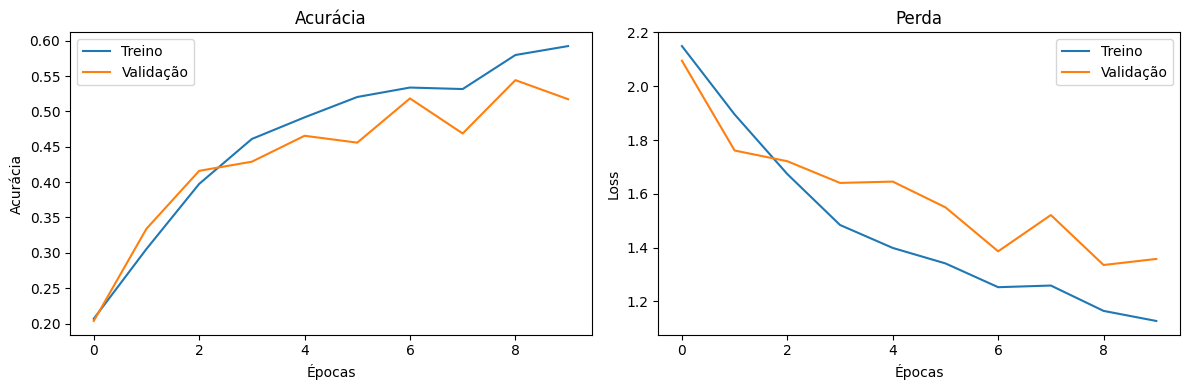

In [ ]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Treino')
plt.plot(history.history['val_accuracy'], label='Validação')
plt.title('Acurácia')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Treino')
plt.plot(history.history['val_loss'], label='Validação')
plt.title('Perda')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


Ordem das classes: ['Cardboard', 'Food Organics', 'Glass', 'Metal', 'Miscellaneous Trash', 'Paper', 'Plastic', 'Textile Trash', 'Vegetation']
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 729ms/step


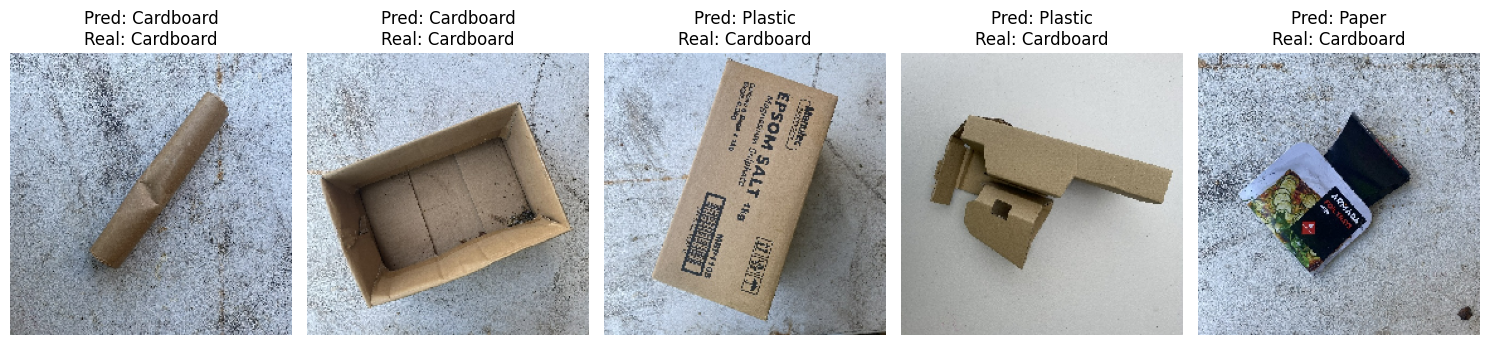

In [ ]:
class_names = list(train_generator.class_indices.keys())
print("Ordem das classes:", class_names)

# Obtemos um lote do gerador
test_generator.reset()  # para garantir início
x_test, y_test = next(test_generator)  # pega um batch
predictions = model.predict(x_test)

def interpret_prediction(pred):
    """ Recebe o vetor de probabilidades (ex: [0.1, 0.7, 0.1, 0.1]) e retorna a classe de maior score. """
    idx = np.argmax(pred)
    return class_names[idx]

plt.figure(figsize=(15,5))
for i in range(5):  # mostrar 5 exemplos
    ax = plt.subplot(1,5, i+1)
    plt.imshow(x_test[i])
    true_idx = np.argmax(y_test[i])
    pred_label = interpret_prediction(predictions[i])
    true_label = class_names[true_idx]
    plt.title(f"Pred: {pred_label}\nReal: {true_label}")
    plt.axis("off")

plt.tight_layout()
plt.show()
